In [2]:
import sys
from gensim.utils import simple_preprocess

import gensim
from pprint import pprint
import spacy
import gensim.corpora as corpora
from gensim.models import TfidfModel
from gensim.models import LdaModel

print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['E:\\LDA_Abstract_README', 'E:/LDA_Abstract_README'])
from utils import load_data

n_topics = [10, 20, 27, 30]
n_docs = 10000


textPre_FilePath = "../data/readme_corpus.txt"
lda_ModelPath = "./readme_model/"


def sent_to_words(sentences):
    for sentence in sentences:
        yield gensim.utils.simple_preprocess(str(sentence), deacc=True)  # deacc=True removes punctuations

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, notAllowed_postags=None):
    """https://spacy.io/api/annotation"""
    if notAllowed_postags is None:
        notAllowed_postags = ['ADJ', 'ADV']
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ not in notAllowed_postags])
    return texts_out

data = load_data(textPre_FilePath)[:n_docs]
data_words = list(sent_to_words(data))
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, notAllowed_postags=['ADJ', 'ADV'])


# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# 创建TF-IDF模型并应用于整个语料库
tfidf_model = TfidfModel(corpus)
corpus = tfidf_model[corpus]

Python 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)] on win32


[nltk_data] Downloading package stopwords to E:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
n_t = 0
n_top_words = 10
models = []
for n_t in n_topics:
    lda = LdaModel.load(lda_ModelPath+'lda_readme'+str(n_t))
    models.append(lda)


# Top words

In [4]:
# Print the Keyword in the 10 topics
for model in models:
    pprint(model.print_topics(num_words=n_top_words))
# doc_lda = lda_model[corpus]

[(0,
  '0.000*"phyre" + 0.000*"flownet" + 0.000*"tenni" + 0.000*"censu" + '
  '0.000*"plate" + 0.000*"breast" + 0.000*"sparql" + 0.000*"tener" + '
  '0.000*"raft" + 0.000*"vot"'),
 (1,
  '0.001*"mot" + 0.000*"lightgbm" + 0.000*"mathematica" + 0.000*"sde" + '
  '0.000*"kalman" + 0.000*"micro_express" + 0.000*"floodsung" + '
  '0.000*"multifit" + 0.000*"coqa" + 0.000*"pcrnet"'),
 (2,
  '0.005*"googl" + 0.005*"research" + 0.004*"git" + 0.003*"clone" + '
  '0.003*"trunk_subdir" + 0.003*"foo_svn" + 0.003*"interest_subdir" + '
  '0.002*"creativecommon" + 0.002*"histori" + 0.002*"recommend"'),
 (3,
  '0.000*"leakag" + 0.000*"banana_banana" + 0.000*"gqa" + 0.000*"coreset" + '
  '0.000*"superresolut" + 0.000*"disast" + 0.000*"vilbert" + 0.000*"mia" + '
  '0.000*"motif" + 0.000*"mpg_caption"'),
 (4,
  '0.009*"readm" + 0.008*"huggingfac" + 0.007*"co" + 0.007*"md" + '
  '0.005*"transform" + 0.004*"timm" + 0.004*"maxvit" + 0.003*"ft" + '
  '0.003*"doc" + 0.003*"vit"'),
 (5,
  '0.004*"darknet" + 0.0

# UMASS

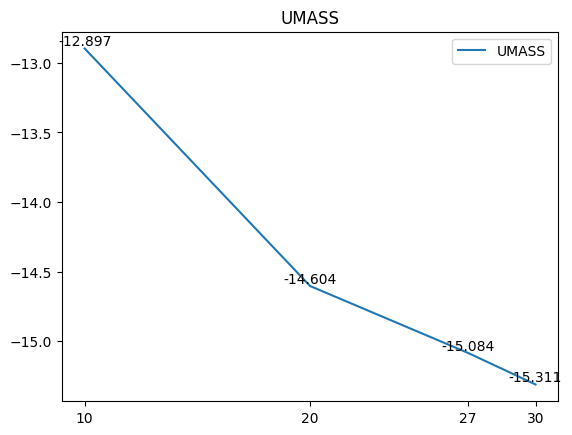

In [5]:
import numpy as np
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
measures = []

u_mass_value = []
for i, model in enumerate(models):
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=model, texts=data_lemmatized, dictionary=id2word, coherence='u_mass')
    coherence_lda = coherence_model_lda.get_coherence()
    u_mass_value.append(coherence_lda)
    measures.append([])
    measures[i].append(coherence_lda)

plt.figure()
plt.plot(n_topics, np.array(u_mass_value), label="UMASS")
for i in range(len(n_topics)):
    plt.text(n_topics[i], u_mass_value[i], str(u_mass_value[i])[:7], ha='center', va='bottom')
plt.xticks(n_topics)
plt.title('UMASS')
plt.legend()
plt.show()

# NPMI

In [ ]:
import numpy as np
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

u_npmi_value = []
for i, model in enumerate(models):
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=model, texts=data_lemmatized, dictionary=id2word, coherence='c_npmi')
    coherence_lda = coherence_model_lda.get_coherence()
    u_npmi_value.append(coherence_lda)
    measures[i].append(coherence_lda)

plt.figure()
plt.plot(n_topics, np.array(u_npmi_value), label="NPMI")
for i in range(len(n_topics)):
    plt.text(n_topics[i], u_npmi_value[i], str(u_npmi_value[i])[:7], ha='center', va='bottom')
plt.xticks(n_topics)
plt.title('NPMI')
plt.legend()
plt.show()

# Coherence Value

In [ ]:
import numpy as np
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

coherence_value = []
for i, model in enumerate(models):
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_value.append(coherence_lda)
    measures[i].append(coherence_lda)

plt.figure()
plt.plot(n_topics, np.array(coherence_value), label="Topic Coherence")
for i in range(len(n_topics)):
    plt.text(n_topics[i], coherence_value[i], str(coherence_value[i])[:7], ha='center', va='bottom')
plt.xticks(n_topics)
plt.title('Topic Coherence')
plt.legend()
plt.show()

In [ ]:
import pandas as pd

performance = pd.DataFrame(measures, columns=['UMASS', 'NPMI', "Topic Coherence"])
performance